<sub>Developed by SeongKu Kang, August 2025 — Do not distribute</sub>

# 📘 Task 2: ESCI Product Classification (Fixed Embeddings)

In this notebook, we will explore **classification tasks on the ESCI dataset** using precomputed BERT embeddings for queries and documents.  
We will first build a lightweight model on top of fixed embeddings, rather than fine-tuning BERT itself.

Specifically, we will train an **MLP classifier** using concatenated **query + document embeddings**.  
Our goal is to predict **ESCI labels**:
  - **E** (Exact)  
  - **S** (Substitute)  
  - **C** (Complement)  
  - **I** (Irrelevant)  


### What’s Different from Previous Work?
- In earlier notebooks, **labels were attached only to documents (products)**.  
- Here, **labels are defined for each query–document pair**.  
  - The same product may have different labels depending on the query.  
  - Example:  
    - Query: *"iPhone 13 case"*  
      - Document: *"Apple iPhone 13 silicone case"* → **E**  
      - Document: *"Apple iPhone 12 case"* → **S**  
      - Document: *"Apple AirPods"* → **C**  
      - Document: *"Samsung Galaxy S21 case"* → **I**  

This makes the task more challenging and realistic, as relevance depends on the **interaction between query and product**.

In [1]:
import json
import random
from tqdm import tqdm
from pathlib import Path
from utils import * 
import copy

import pandas as pd
from collections import Counter

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# === 1. Path config ===
ROOT = Path("dataset")
EMB_PATH = ROOT / "corpus_bert_mean.pt"

# === 2. Load document embeddings ===
corpus_data     = torch.load(EMB_PATH)                     # {"ids": [...], "embeddings": Tensor}
pid_list        = corpus_data["ids"]                       # product IDs
pid2idx         = {pid: i for i, pid in enumerate(pid_list)}  # mapping: pid → index
doc_embeddings  = corpus_data["embeddings"]                # (N_docs, D)

# === 3. Load query embeddings (train) ===
QUERY_EMB_PATH  = ROOT / "queries_1k_bert_mean.pt"
query_data      = torch.load(QUERY_EMB_PATH)               # {"ids": [...], "embeddings": Tensor}
qid_list        = query_data["ids"]                        # query IDs
qid2idx         = {qid: i for i, qid in enumerate(qid_list)}  # mapping: qid → index
query_embeddings = query_data["embeddings"]                # (N_queries, D)

# === 4. Load query embeddings (test) ===
TEST_QUERY_EMB_PATH = ROOT / "test_queries_bert_mean.pt"
test_query_data     = torch.load(TEST_QUERY_EMB_PATH)      # {"ids": [...], "embeddings": Tensor}
test_qid_list       = test_query_data["ids"]               # test query IDs
test_qid2idx        = {qid: i for i, qid in enumerate(test_qid_list)}  # mapping: qid → index
test_query_embeddings = test_query_data["embeddings"]      # (N_test_queries, D)

In [3]:
# === ESCI label mapping ===
esci_label2id = {"E": 0, "S": 1, "C": 2, "I": 3}
esci_id2label = {0: "E", 1: "S", 2: "C", 3: "I"}

def load_qrels(path, esci_label2id):
    """
    Load qrels file (query-document relevance labels).
    - Keeps only rows with ESCI labels (E/S/C/I).
    - Maps string labels to numeric IDs.
    """
    df = pd.read_csv(path, sep="\t", header=0)        # read TSV with header
    df = df[df["label"].isin(esci_label2id)]          # filter invalid labels
    df["label_idx"] = df["label"].map(esci_label2id)  # map to numeric IDs
    return df

# === Load qrels (train & test) ===
QRELS_TRAIN_PATH = ROOT / "qrels_1k.tsv"
QRELS_TEST_PATH = ROOT / "qrels_test.tsv"

train_qrels_df = load_qrels(QRELS_TRAIN_PATH, esci_label2id)
test_qrels_df = load_qrels(QRELS_TEST_PATH, esci_label2id)

train_qrels_df.head(3), test_qrels_df.head(3)

(   query-id   corpus-id label  label_idx
 0     17397  B07R9HPJPW     E          0
 1     17397  B07Q34YJ4T     E          0
 2     17397  B07NH217CV     E          0,
    query-id   corpus-id label  label_idx
 0     12712  B081FY5ZYQ     S          1
 1     12712  B07X45P8C3     S          1
 2     12712  B07V9PPK61     S          1)

In [4]:
# === Check label distribution in training set ===
train_dist = Counter(train_qrels_df["label_idx"])
train_summary = ", ".join(f"{esci_id2label[k]}: {v}" for k, v in sorted(train_dist.items()))
print(f"[Train] {train_summary}")

# === Check label distribution in test set ===
test_dist = Counter(test_qrels_df["label_idx"])
test_summary = ", ".join(f"{esci_id2label[k]}: {v}" for k, v in sorted(test_dist.items()))
print(f"[Test]  {test_summary}")

[Train] E: 9237, S: 6870, C: 915, I: 3281
[Test]  E: 4720, S: 3270, C: 447, I: 1712


   
Since each **query–document pair has its own ESCI label**, the training instances are naturally represented as **triplets** `(query_id, product_id, label_idx)`.  
Here we construct these triplets, ensuring that both query and product embeddings exist, so they can later be fed into our classification model.

In [5]:
def build_triplets(qrels_df, qid2idx, pid2idx):
    """
    Construct (query_id, product_id, label_idx) triplets.
    Keep only pairs where both query and product embeddings exist.
    """
    triplets = []
    for row in qrels_df.itertuples(index=False):
        qid, pid, label = row[0], row[1], row[-1]  # query, product, label_idx
        if qid in qid2idx and pid in pid2idx:     # ensure embeddings exist
            triplets.append((qid, pid, label))
    return triplets

# Build train/test triplets for ESCI classification
train_triplets = build_triplets(train_qrels_df, qid2idx, pid2idx)
test_triplets = build_triplets(test_qrels_df, test_qid2idx, pid2idx)

print(f"# Train triplets: {len(train_triplets)}")
print(f"# Test triplets:  {len(test_triplets)}")

# Train triplets: 20303
# Test triplets:  10149


In [6]:
class ESCIClassificationDataset(Dataset):
    def __init__(self, triplets, qid2idx, query_embeddings, pid2idx, doc_embeddings):
        # triplets: list of (query_id, doc_id, label_idx)
        # qid2idx / pid2idx: maps query/product IDs → embedding index
        # query_embeddings / doc_embeddings: precomputed BERT embeddings
        self.triplets = triplets
        self.qid2idx = qid2idx
        self.query_embeddings = query_embeddings
        self.pid2idx = pid2idx
        self.doc_embeddings = doc_embeddings

    def __len__(self):
        # number of training instances
        return len(self.triplets)

    def __getitem__(self, idx):
        # fetch one instance: query embedding + doc embedding → concatenated input
        qid, pid, label = self.triplets[idx]
        q_emb = self.query_embeddings[self.qid2idx[qid]]
        d_emb = self.doc_embeddings[self.pid2idx[pid]]
        x = torch.cat([q_emb, d_emb], dim=-1)     # input vector
        y = torch.tensor(label, dtype=torch.long) # target label
        return {"X": x, "y": y}

In [7]:
from collections import defaultdict
from sklearn.metrics import accuracy_score, f1_score

def evaluate(model, dataloader, device="cpu", num_classes=None):
    """
    Evaluate classification model performance.

    Returns:
        dict with overall accuracy, macro F1, and per-class accuracy
    """
    model.eval()  # set model to evaluation mode (no dropout, etc.)
    all_preds, all_labels = [], []

    with torch.no_grad():  
        for batch in dataloader:
            X = batch["X"].to(device)  # input features
            y = batch["y"].to(device)  # true labels
            logits = model(X)          # forward pass
            preds = torch.argmax(logits, dim=1)  # predicted class
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())

    # === Overall metrics ===
    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    # === Per-class accuracy ===
    class_correct = defaultdict(int)  # count of correct predictions per class
    class_total = defaultdict(int)    # count of total examples per class
    
    for y_true, y_pred in zip(all_labels, all_preds):
        class_total[y_true] += 1
        if y_true == y_pred:
            class_correct[y_true] += 1

    per_class_acc = {}
    # If num_classes is provided, ensure all classes are included in output
    class_range = range(num_classes) if num_classes is not None else sorted(class_total.keys())
    for cls in class_range:
        total = class_total[cls]
        correct = class_correct[cls]
        per_class_acc[cls] = correct / total if total > 0 else 0.0

    return {
        "accuracy": acc,
        "f1_macro": f1_macro,
        "per_class_accuracy": per_class_acc
    }

## [Part A] Standard training

In [8]:
import torch.nn as nn

class BaseClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=126, num_classes=4, dropout_rate=0.1):
        """
        Simple MLP classifier for ESCI classification.

        Args:
            input_dim (int): Dimension of concatenated query+doc embeddings
            hidden_dim (int): Size of hidden layer
            num_classes (int): Number of output classes (E, S, C, I)
            dropout_rate (float): Dropout applied on input embeddings
        """
        super().__init__()
        
        # Dropout applied directly to input embeddings
        self.dropout_embedding = nn.Dropout(dropout_rate)
        
        # Multi-layer feedforward classifier
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # projection to hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),                   # regularization
            nn.Linear(hidden_dim, hidden_dim), # second hidden layer
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes) # output logits
        )

    def forward(self, x):
        """
        Forward pass through the classifier.
        """
        x = self.dropout_embedding(x)  # apply dropout on embeddings
        return self.classifier(x)      # return logits (before softmax)

In [9]:
# Test dataset & loader
test_dataset = ESCIClassificationDataset(test_triplets, test_qid2idx, test_query_embeddings, pid2idx, doc_embeddings)
test_loader = DataLoader(test_dataset, batch_size=128)  

results_dict = {'valid':{}, 'test': {}}

In [10]:
# Split train/val (80/20)
random.shuffle(train_triplets)
val_size = int(len(train_triplets) * 0.2)
val_triplets, train_triplets = train_triplets[:val_size], train_triplets[val_size:]

# Dataset & Loader
train_dataset, val_dataset = ESCIClassificationDataset(train_triplets, qid2idx, query_embeddings, pid2idx, doc_embeddings), \
                             ESCIClassificationDataset(val_triplets, qid2idx, query_embeddings, pid2idx, doc_embeddings)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

In [11]:
# Model & optimizer
input_dim = query_embeddings.size(1) + doc_embeddings.size(1)
model = BaseClassifier(input_dim, hidden_dim=126, num_classes=4).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, eps=1e-8, weight_decay=0.01)

In [12]:
best_val_acc = -1
best_model_state = None
patience = 5
patience_counter = 0

val_acc_list = []
test_acc_list = []

EPOCHS = 500

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        X = batch["X"].to(device)
        y = batch["y"].to(device)
        logits = model(X)
        loss = F.cross_entropy(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"[Epoch {epoch}] Train Loss: {avg_loss:.4f}")

    # === Validation ===
    val_result = evaluate(model, val_loader, device=device)
    val_acc = val_result["f1_macro"]
    val_acc_list.append(val_acc)

    is_improved = val_acc > best_val_acc
    print_eval_result_esci(val_result, stage="val", is_improved=is_improved)

    # === Test ===
    test_result = evaluate(model, test_loader, device=device)
    test_acc = test_result["f1_macro"]
    test_acc_list.append(test_acc)
    print_eval_result_esci(test_result, stage="test")

    # === Update best model ===
    if is_improved:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1

    # === Early stopping ===
    if patience_counter >= patience:
        print(f"[Early Stopping] No improvement for {patience} consecutive epochs.")
        break

Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 70.26it/s]


[Epoch 1] Train Loss: 1.2412
[VAL ] Acc: 0.4596 | F1-macro: 0.1574 *
        E: 1.0000 | S: 0.0000 | C: 0.0000 | I: 0.0000
[TEST] Acc: 0.4651 | F1-macro: 0.1587
        E: 1.0000 | S: 0.0000 | C: 0.0000 | I: 0.0000


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 106.19it/s]


[Epoch 2] Train Loss: 1.1532
[VAL ] Acc: 0.4596 | F1-macro: 0.1574
        E: 1.0000 | S: 0.0000 | C: 0.0000 | I: 0.0000
[TEST] Acc: 0.4651 | F1-macro: 0.1587
        E: 1.0000 | S: 0.0000 | C: 0.0000 | I: 0.0000


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 101.07it/s]


[Epoch 3] Train Loss: 1.1422
[VAL ] Acc: 0.4611 | F1-macro: 0.1619 *
        E: 0.9968 | S: 0.0088 | C: 0.0000 | I: 0.0000
[TEST] Acc: 0.4658 | F1-macro: 0.1621
        E: 0.9966 | S: 0.0070 | C: 0.0000 | I: 0.0000


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 103.27it/s]


[Epoch 4] Train Loss: 1.1320
[VAL ] Acc: 0.4660 | F1-macro: 0.1912 *
        E: 0.9636 | S: 0.0627 | C: 0.0000 | I: 0.0136
[TEST] Acc: 0.4640 | F1-macro: 0.1801
        E: 0.9650 | S: 0.0440 | C: 0.0000 | I: 0.0058


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 104.22it/s]


[Epoch 5] Train Loss: 1.1182
[VAL ] Acc: 0.4793 | F1-macro: 0.2487 *
        E: 0.8842 | S: 0.1910 | C: 0.0000 | I: 0.0560
[TEST] Acc: 0.4710 | F1-macro: 0.2387
        E: 0.8792 | S: 0.1636 | C: 0.0000 | I: 0.0555


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 100.26it/s]


[Epoch 6] Train Loss: 1.1063
[VAL ] Acc: 0.4961 | F1-macro: 0.2871 *
        E: 0.8499 | S: 0.2618 | C: 0.0000 | I: 0.1104
[TEST] Acc: 0.4739 | F1-macro: 0.2618
        E: 0.8411 | S: 0.2080 | C: 0.0000 | I: 0.0935


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 104.84it/s]


[Epoch 7] Train Loss: 1.0946
[VAL ] Acc: 0.4953 | F1-macro: 0.2962 *
        E: 0.8210 | S: 0.2913 | C: 0.0000 | I: 0.1271
[TEST] Acc: 0.4716 | F1-macro: 0.2695
        E: 0.8142 | S: 0.2315 | C: 0.0000 | I: 0.1086


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 103.70it/s]


[Epoch 8] Train Loss: 1.0845
[VAL ] Acc: 0.4975 | F1-macro: 0.3074 *
        E: 0.7862 | S: 0.3400 | C: 0.0000 | I: 0.1392
[TEST] Acc: 0.4685 | F1-macro: 0.2792
        E: 0.7625 | S: 0.2939 | C: 0.0000 | I: 0.1139


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 101.87it/s]


[Epoch 9] Train Loss: 1.0722
[VAL ] Acc: 0.4998 | F1-macro: 0.3007
        E: 0.8248 | S: 0.2979 | C: 0.0000 | I: 0.1301
[TEST] Acc: 0.4670 | F1-macro: 0.2629
        E: 0.8074 | S: 0.2370 | C: 0.0000 | I: 0.0900


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 102.18it/s]


[Epoch 10] Train Loss: 1.0634
[VAL ] Acc: 0.5049 | F1-macro: 0.3265 *
        E: 0.7465 | S: 0.3982 | C: 0.0000 | I: 0.1770
[TEST] Acc: 0.4637 | F1-macro: 0.2898
        E: 0.7081 | S: 0.3437 | C: 0.0000 | I: 0.1402


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 100.02it/s]


[Epoch 11] Train Loss: 1.0503
[VAL ] Acc: 0.5030 | F1-macro: 0.3163
        E: 0.7990 | S: 0.3230 | C: 0.0000 | I: 0.1710
[TEST] Acc: 0.4676 | F1-macro: 0.2783
        E: 0.7748 | S: 0.2670 | C: 0.0000 | I: 0.1262


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 103.12it/s]


[Epoch 12] Train Loss: 1.0428
[VAL ] Acc: 0.5116 | F1-macro: 0.3401 *
        E: 0.7176 | S: 0.4513 | C: 0.0056 | I: 0.1891
[TEST] Acc: 0.4585 | F1-macro: 0.2894
        E: 0.6733 | S: 0.3832 | C: 0.0022 | I: 0.1291


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 100.74it/s]


[Epoch 13] Train Loss: 1.0331
[VAL ] Acc: 0.5128 | F1-macro: 0.3409 *
        E: 0.7631 | S: 0.3857 | C: 0.0113 | I: 0.2012
[TEST] Acc: 0.4623 | F1-macro: 0.2859
        E: 0.7242 | S: 0.3211 | C: 0.0045 | I: 0.1297


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 104.29it/s]


[Epoch 14] Train Loss: 1.0242
[VAL ] Acc: 0.5118 | F1-macro: 0.3422 *
        E: 0.7203 | S: 0.4491 | C: 0.0113 | I: 0.1861
[TEST] Acc: 0.4572 | F1-macro: 0.2870
        E: 0.6805 | S: 0.3761 | C: 0.0089 | I: 0.1133


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 100.29it/s]


[Epoch 15] Train Loss: 1.0184
[VAL ] Acc: 0.5212 | F1-macro: 0.3571 *
        E: 0.7395 | S: 0.4292 | C: 0.0169 | I: 0.2284
[TEST] Acc: 0.4563 | F1-macro: 0.2897
        E: 0.6867 | S: 0.3535 | C: 0.0089 | I: 0.1343


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 103.07it/s]


[Epoch 16] Train Loss: 1.0074
[VAL ] Acc: 0.5236 | F1-macro: 0.3585 *
        E: 0.7497 | S: 0.4351 | C: 0.0282 | I: 0.1997
[TEST] Acc: 0.4578 | F1-macro: 0.2872
        E: 0.6919 | S: 0.3624 | C: 0.0134 | I: 0.1104


Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 105.16it/s]


[Epoch 17] Train Loss: 1.0014
[VAL ] Acc: 0.5273 | F1-macro: 0.3824 *
        E: 0.7492 | S: 0.4322 | C: 0.0734 | I: 0.2179
[TEST] Acc: 0.4565 | F1-macro: 0.2918
        E: 0.6833 | S: 0.3624 | C: 0.0157 | I: 0.1262


Epoch 18: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 99.98it/s]


[Epoch 18] Train Loss: 0.9943
[VAL ] Acc: 0.5313 | F1-macro: 0.3971 *
        E: 0.7663 | S: 0.3982 | C: 0.0960 | I: 0.2572
[TEST] Acc: 0.4561 | F1-macro: 0.2911
        E: 0.7028 | S: 0.3275 | C: 0.0179 | I: 0.1361


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 103.10it/s]


[Epoch 19] Train Loss: 0.9872
[VAL ] Acc: 0.5296 | F1-macro: 0.3860
        E: 0.6999 | S: 0.5007 | C: 0.0565 | I: 0.2345
[TEST] Acc: 0.4483 | F1-macro: 0.2889
        E: 0.6242 | S: 0.4294 | C: 0.0134 | I: 0.1133


Epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 105.82it/s]


[Epoch 20] Train Loss: 0.9802
[VAL ] Acc: 0.5355 | F1-macro: 0.4078 *
        E: 0.7256 | S: 0.4535 | C: 0.0904 | I: 0.2859
[TEST] Acc: 0.4483 | F1-macro: 0.2913
        E: 0.6523 | S: 0.3758 | C: 0.0157 | I: 0.1373


Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 105.56it/s]


[Epoch 21] Train Loss: 0.9740
[VAL ] Acc: 0.5369 | F1-macro: 0.4147 *
        E: 0.7631 | S: 0.4093 | C: 0.1299 | I: 0.2693
[TEST] Acc: 0.4566 | F1-macro: 0.2945
        E: 0.6949 | S: 0.3394 | C: 0.0224 | I: 0.1367


Epoch 22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 98.56it/s]


[Epoch 22] Train Loss: 0.9698
[VAL ] Acc: 0.5369 | F1-macro: 0.4092
        E: 0.6811 | S: 0.5487 | C: 0.1130 | I: 0.2194
[TEST] Acc: 0.4451 | F1-macro: 0.2869
        E: 0.5924 | S: 0.4743 | C: 0.0179 | I: 0.0946


Epoch 23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 96.97it/s]


[Epoch 23] Train Loss: 0.9609
[VAL ] Acc: 0.5453 | F1-macro: 0.4304 *
        E: 0.7229 | S: 0.4683 | C: 0.1243 | I: 0.3147
[TEST] Acc: 0.4475 | F1-macro: 0.2977
        E: 0.6383 | S: 0.3853 | C: 0.0224 | I: 0.1513


Epoch 24: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 95.55it/s]


[Epoch 24] Train Loss: 0.9552
[VAL ] Acc: 0.5416 | F1-macro: 0.4083
        E: 0.7883 | S: 0.4004 | C: 0.1130 | I: 0.2496
[TEST] Acc: 0.4631 | F1-macro: 0.2894
        E: 0.7267 | S: 0.3248 | C: 0.0179 | I: 0.1168


Epoch 25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 99.26it/s]


[Epoch 25] Train Loss: 0.9489
[VAL ] Acc: 0.5532 | F1-macro: 0.4279
        E: 0.7310 | S: 0.5052 | C: 0.1186 | I: 0.2663
[TEST] Acc: 0.4496 | F1-macro: 0.2896
        E: 0.6390 | S: 0.4107 | C: 0.0157 | I: 0.1151


Epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 102.15it/s]


[Epoch 26] Train Loss: 0.9450
[VAL ] Acc: 0.5549 | F1-macro: 0.4336 *
        E: 0.7476 | S: 0.4816 | C: 0.1299 | I: 0.2753
[TEST] Acc: 0.4508 | F1-macro: 0.2892
        E: 0.6576 | S: 0.3853 | C: 0.0157 | I: 0.1192


Epoch 27: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 100.67it/s]


[Epoch 27] Train Loss: 0.9370
[VAL ] Acc: 0.5559 | F1-macro: 0.4378 *
        E: 0.7438 | S: 0.4816 | C: 0.1356 | I: 0.2905
[TEST] Acc: 0.4484 | F1-macro: 0.2909
        E: 0.6483 | S: 0.3893 | C: 0.0201 | I: 0.1221


Epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 103.06it/s]


[Epoch 28] Train Loss: 0.9299
[VAL ] Acc: 0.5599 | F1-macro: 0.4464 *
        E: 0.7744 | S: 0.4314 | C: 0.1469 | I: 0.3283
[TEST] Acc: 0.4511 | F1-macro: 0.2939
        E: 0.6894 | S: 0.3211 | C: 0.0224 | I: 0.1542


Epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 101.14it/s]


[Epoch 29] Train Loss: 0.9275
[VAL ] Acc: 0.5586 | F1-macro: 0.4347
        E: 0.7814 | S: 0.4410 | C: 0.1299 | I: 0.2859
[TEST] Acc: 0.4572 | F1-macro: 0.2868
        E: 0.7032 | S: 0.3422 | C: 0.0157 | I: 0.1139


Epoch 30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 101.15it/s]


[Epoch 30] Train Loss: 0.9202
[VAL ] Acc: 0.5589 | F1-macro: 0.4435
        E: 0.7395 | S: 0.4963 | C: 0.1412 | I: 0.2890
[TEST] Acc: 0.4493 | F1-macro: 0.2902
        E: 0.6447 | S: 0.4018 | C: 0.0201 | I: 0.1133


Epoch 31: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 104.38it/s]

[Epoch 31] Train Loss: 0.9130


[VAL ] Acc: 0.5606 | F1-macro: 0.4683 *
        E: 0.6581 | S: 0.5760 | C: 0.1808 | I: 0.3555
[TEST] Acc: 0.4315 | F1-macro: 0.2978
        E: 0.5367 | S: 0.4813 | C: 0.0291 | I: 0.1513


Epoch 32: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 104.42it/s]


[Epoch 32] Train Loss: 0.9107
[VAL ] Acc: 0.5631 | F1-macro: 0.4616
        E: 0.6785 | S: 0.5723 | C: 0.1582 | I: 0.3268
[TEST] Acc: 0.4441 | F1-macro: 0.2956
        E: 0.5699 | S: 0.4881 | C: 0.0201 | I: 0.1238


Epoch 33: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 105.19it/s]


[Epoch 33] Train Loss: 0.9080
[VAL ] Acc: 0.5667 | F1-macro: 0.4720 *
        E: 0.6854 | S: 0.5597 | C: 0.1921 | I: 0.3464
[TEST] Acc: 0.4420 | F1-macro: 0.3020
        E: 0.5714 | S: 0.4703 | C: 0.0336 | I: 0.1379


Epoch 34: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 99.79it/s]


[Epoch 34] Train Loss: 0.8986
[VAL ] Acc: 0.5709 | F1-macro: 0.4648
        E: 0.7256 | S: 0.5413 | C: 0.1695 | I: 0.3026
[TEST] Acc: 0.4495 | F1-macro: 0.2895
        E: 0.6191 | S: 0.4456 | C: 0.0179 | I: 0.1022


Epoch 35: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 100.90it/s]


[Epoch 35] Train Loss: 0.8967
[VAL ] Acc: 0.5776 | F1-macro: 0.4820 *
        E: 0.7031 | S: 0.5487 | C: 0.1751 | I: 0.3903
[TEST] Acc: 0.4415 | F1-macro: 0.3010
        E: 0.5824 | S: 0.4416 | C: 0.0224 | I: 0.1624


Epoch 36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 107.74it/s]


[Epoch 36] Train Loss: 0.8934
[VAL ] Acc: 0.5820 | F1-macro: 0.4916 *
        E: 0.7165 | S: 0.5258 | C: 0.1977 | I: 0.4206
[TEST] Acc: 0.4393 | F1-macro: 0.3083
        E: 0.5985 | S: 0.3997 | C: 0.0447 | I: 0.1787


Epoch 37: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 99.72it/s]


[Epoch 37] Train Loss: 0.8871
[VAL ] Acc: 0.5773 | F1-macro: 0.4880
        E: 0.6747 | S: 0.5937 | C: 0.2034 | I: 0.3691
[TEST] Acc: 0.4370 | F1-macro: 0.3046
        E: 0.5443 | S: 0.4902 | C: 0.0425 | I: 0.1425


Epoch 38: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 104.90it/s]


[Epoch 38] Train Loss: 0.8814
[VAL ] Acc: 0.5842 | F1-macro: 0.4931 *
        E: 0.7224 | S: 0.5457 | C: 0.2090 | I: 0.3737
[TEST] Acc: 0.4470 | F1-macro: 0.2997
        E: 0.6140 | S: 0.4242 | C: 0.0268 | I: 0.1402


Epoch 39: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 100.82it/s]


[Epoch 39] Train Loss: 0.8769
[VAL ] Acc: 0.5818 | F1-macro: 0.4940 *
        E: 0.7192 | S: 0.5369 | C: 0.2316 | I: 0.3797
[TEST] Acc: 0.4443 | F1-macro: 0.3077
        E: 0.6091 | S: 0.4153 | C: 0.0515 | I: 0.1478


Epoch 40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 103.04it/s]


[Epoch 40] Train Loss: 0.8765
[VAL ] Acc: 0.5840 | F1-macro: 0.4998 *
        E: 0.6779 | S: 0.5959 | C: 0.2260 | I: 0.3903
[TEST] Acc: 0.4367 | F1-macro: 0.3047
        E: 0.5504 | S: 0.4777 | C: 0.0425 | I: 0.1478


Epoch 41: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 108.64it/s]


[Epoch 41] Train Loss: 0.8700
[VAL ] Acc: 0.5882 | F1-macro: 0.4974
        E: 0.7283 | S: 0.5265 | C: 0.1977 | I: 0.4236
[TEST] Acc: 0.4433 | F1-macro: 0.3041
        E: 0.6117 | S: 0.3972 | C: 0.0291 | I: 0.1752


Epoch 42: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 99.83it/s]


[Epoch 42] Train Loss: 0.8652
[VAL ] Acc: 0.5857 | F1-macro: 0.4965
        E: 0.7090 | S: 0.5642 | C: 0.2147 | I: 0.3812
[TEST] Acc: 0.4414 | F1-macro: 0.3022
        E: 0.5924 | S: 0.4370 | C: 0.0403 | I: 0.1384


Epoch 43: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 104.04it/s]


[Epoch 43] Train Loss: 0.8643
[VAL ] Acc: 0.5897 | F1-macro: 0.5097 *
        E: 0.6699 | S: 0.6187 | C: 0.2373 | I: 0.3979
[TEST] Acc: 0.4297 | F1-macro: 0.2993
        E: 0.5239 | S: 0.4988 | C: 0.0403 | I: 0.1396


Epoch 44: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 104.84it/s]


[Epoch 44] Train Loss: 0.8593
[VAL ] Acc: 0.5924 | F1-macro: 0.5093
        E: 0.7299 | S: 0.5310 | C: 0.2373 | I: 0.4251
[TEST] Acc: 0.4409 | F1-macro: 0.3073
        E: 0.6121 | S: 0.3899 | C: 0.0470 | I: 0.1694


Epoch 45: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 108.75it/s]


[Epoch 45] Train Loss: 0.8533
[VAL ] Acc: 0.5936 | F1-macro: 0.5058
        E: 0.7567 | S: 0.5059 | C: 0.2260 | I: 0.4115
[TEST] Acc: 0.4478 | F1-macro: 0.3017
        E: 0.6561 | S: 0.3550 | C: 0.0358 | I: 0.1583


Epoch 46: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 102.11it/s]


[Epoch 46] Train Loss: 0.8550
[VAL ] Acc: 0.5943 | F1-macro: 0.4985
        E: 0.7663 | S: 0.4948 | C: 0.1864 | I: 0.4221
[TEST] Acc: 0.4476 | F1-macro: 0.2939
        E: 0.6678 | S: 0.3407 | C: 0.0201 | I: 0.1565


Epoch 47: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 105.44it/s]


[Epoch 47] Train Loss: 0.8489
[VAL ] Acc: 0.6002 | F1-macro: 0.5206 *
        E: 0.6774 | S: 0.6180 | C: 0.2260 | I: 0.4463
[TEST] Acc: 0.4259 | F1-macro: 0.2960
        E: 0.5197 | S: 0.4856 | C: 0.0291 | I: 0.1565


Epoch 48: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 104.98it/s]


[Epoch 48] Train Loss: 0.8436
[VAL ] Acc: 0.5941 | F1-macro: 0.5098
        E: 0.7095 | S: 0.5841 | C: 0.2486 | I: 0.3812
[TEST] Acc: 0.4371 | F1-macro: 0.3027
        E: 0.5697 | S: 0.4584 | C: 0.0492 | I: 0.1320


Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 105.70it/s]


[Epoch 49] Train Loss: 0.8362
[VAL ] Acc: 0.5941 | F1-macro: 0.5096
        E: 0.6870 | S: 0.6232 | C: 0.2316 | I: 0.3691
[TEST] Acc: 0.4288 | F1-macro: 0.2908
        E: 0.5292 | S: 0.5009 | C: 0.0313 | I: 0.1180


Epoch 50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 100.21it/s]


[Epoch 50] Train Loss: 0.8333
[VAL ] Acc: 0.6010 | F1-macro: 0.5267 *
        E: 0.7422 | S: 0.5273 | C: 0.2881 | I: 0.4372
[TEST] Acc: 0.4420 | F1-macro: 0.3088
        E: 0.6288 | S: 0.3688 | C: 0.0582 | I: 0.1671


Epoch 51: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 105.26it/s]


[Epoch 51] Train Loss: 0.8322
[VAL ] Acc: 0.5988 | F1-macro: 0.5119
        E: 0.7449 | S: 0.5383 | C: 0.2316 | I: 0.4085
[TEST] Acc: 0.4435 | F1-macro: 0.2965
        E: 0.6337 | S: 0.3856 | C: 0.0336 | I: 0.1367


Epoch 52: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 105.26it/s]


[Epoch 52] Train Loss: 0.8317
[VAL ] Acc: 0.6067 | F1-macro: 0.5255
        E: 0.7262 | S: 0.5590 | C: 0.2316 | I: 0.4675
[TEST] Acc: 0.4372 | F1-macro: 0.3032
        E: 0.5972 | S: 0.3979 | C: 0.0358 | I: 0.1758


Epoch 53: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 106.00it/s]


[Epoch 53] Train Loss: 0.8259
[VAL ] Acc: 0.6032 | F1-macro: 0.5262
        E: 0.7042 | S: 0.5833 | C: 0.2542 | I: 0.4523
[TEST] Acc: 0.4345 | F1-macro: 0.3050
        E: 0.5716 | S: 0.4318 | C: 0.0447 | I: 0.1636


Epoch 54: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 105.65it/s]


[Epoch 54] Train Loss: 0.8243
[VAL ] Acc: 0.6062 | F1-macro: 0.5263
        E: 0.7262 | S: 0.5634 | C: 0.2486 | I: 0.4508
[TEST] Acc: 0.4354 | F1-macro: 0.2978
        E: 0.6002 | S: 0.3997 | C: 0.0358 | I: 0.1536


Epoch 55: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 105.51it/s]


[Epoch 55] Train Loss: 0.8175
[VAL ] Acc: 0.6074 | F1-macro: 0.5313 *
        E: 0.7288 | S: 0.5531 | C: 0.2655 | I: 0.4675
[TEST] Acc: 0.4380 | F1-macro: 0.3069
        E: 0.6110 | S: 0.3749 | C: 0.0470 | I: 0.1834


Epoch 56: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 105.22it/s]


[Epoch 56] Train Loss: 0.8164
[VAL ] Acc: 0.6064 | F1-macro: 0.5396 *
        E: 0.6817 | S: 0.6158 | C: 0.3164 | I: 0.4523
[TEST] Acc: 0.4215 | F1-macro: 0.3021
        E: 0.5242 | S: 0.4590 | C: 0.0559 | I: 0.1624


Epoch 57: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 105.43it/s]


[Epoch 57] Train Loss: 0.8130
[VAL ] Acc: 0.6071 | F1-macro: 0.5234
        E: 0.7213 | S: 0.5863 | C: 0.2316 | I: 0.4281
[TEST] Acc: 0.4345 | F1-macro: 0.2997
        E: 0.5822 | S: 0.4193 | C: 0.0336 | I: 0.1612


Epoch 58: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 104.69it/s]

[Epoch 58] Train Loss: 0.8064


[VAL ] Acc: 0.6101 | F1-macro: 0.5284
        E: 0.7294 | S: 0.5671 | C: 0.2373 | I: 0.4614
[TEST] Acc: 0.4314 | F1-macro: 0.2996
        E: 0.5936 | S: 0.3859 | C: 0.0380 | I: 0.1735


Epoch 59: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 105.54it/s]


[Epoch 59] Train Loss: 0.8070
[VAL ] Acc: 0.6089 | F1-macro: 0.5226
        E: 0.7272 | S: 0.5841 | C: 0.2260 | I: 0.4281
[TEST] Acc: 0.4397 | F1-macro: 0.2982
        E: 0.5958 | S: 0.4242 | C: 0.0291 | I: 0.1466


Epoch 60: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 104.96it/s]


[Epoch 60] Train Loss: 0.8029
[VAL ] Acc: 0.6081 | F1-macro: 0.5184
        E: 0.7111 | S: 0.6069 | C: 0.2090 | I: 0.4266
[TEST] Acc: 0.4306 | F1-macro: 0.2951
        E: 0.5519 | S: 0.4602 | C: 0.0291 | I: 0.1443


Epoch 61: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 105.59it/s]


[Epoch 61] Train Loss: 0.8012
[VAL ] Acc: 0.6135 | F1-macro: 0.5389
        E: 0.6902 | S: 0.6239 | C: 0.2599 | I: 0.4705
[TEST] Acc: 0.4247 | F1-macro: 0.3002
        E: 0.5275 | S: 0.4664 | C: 0.0425 | I: 0.1612
[Early Stopping] No improvement for 5 consecutive epochs.


[Epoch 46] Train Loss: 0.8433
[VAL ] Acc: 0.5869 | F1-macro: 0.4950 | F1-micro: 0.5869
        E: 0.7576 | S: 0.5030 | C: 0.2194 | I: 0.3629
[TEST] Acc: 0.4500 | F1-macro: 0.2864 | F1-micro: 0.4500
        E: 0.6826 | S: 0.3489 | C: 0.0224 | I: 0.1133
[Early Stopping] No improvement for 5 consecutive epochs.


In [13]:
model.load_state_dict(best_model_state)
final_test_result = evaluate(model, test_loader, device=device)
print_eval_result_esci(final_test_result, stage="final_test")

results_dict['valid']['base_train'] = val_acc_list[:]
results_dict['test']['base_train'] = test_acc_list[:]

[FINAL_TEST] Acc: 0.4215 | F1-macro: 0.3021
        E: 0.5242 | S: 0.4590 | C: 0.0559 | I: 0.1624


---
## [Part B] Multi-Task Learning (MTL) Extension  

In addition to single-task classification, we will also experiment with **multi-task learning (MTL)** to improve model generalization and representation learning.  

- **Task 1 (Main):** Predict full **ESCI classification** (*E, S, C, I*).  
- **Task 2 (Auxiliary):** Add an auxiliary objective to highlight important distinctions:  
  - **Option A (E vs SCI):** Binary classification where the model distinguishes **strong matches (E)** from all other cases (*S, C, I*).  
  - **Option B (ESC vs I):** Binary classification where the model distinguishes **relevant (E, S, C)** from **irrelevant (I)**.  
  - **Option C (Other variants):** Explore additional formulations (e.g., **E vs S vs CI** collapsed tasks) depending on your hypothesis.  

The auxiliary task may guide the shared representation to capture **different levels of relevance signals**.  
By experimenting with multiple auxiliary task designs, we can analyze which formulation yields the best synergy with the main ESCI classification task.  

In [14]:
import torch
import torch.nn as nn

class MTLClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=126, num_classes=4, dropout_rate=0.1):
        super().__init__()
        # === Shared Encoder ===
        # Both tasks (ESCI 4-class and Binary E-vs-SCI) share this encoder.
        # It projects the concatenated [query_emb, doc_emb] into a compact hidden representation.
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Dropout applied before task-specific heads to regularize embeddings
        self.dropout_embedding = nn.Dropout(dropout_rate)
        
        # === Task-specific Heads ===
        # 1. ESCI head: predicts relevance among {E, S, C, I}
        self.esci_head = nn.Linear(hidden_dim, num_classes)  
        # 2. Binary head: predicts binary target (E vs SCI).
        #    Usually: label=1 if Exact (E), 0 otherwise.
        self.binary_head = nn.Linear(hidden_dim, 1)

    def forward(self, x, train=False):
        """
        Args:
            x (Tensor): Concatenated query+doc embedding of shape (batch, input_dim).
            train (bool): 
                - True: return logits for both ESCI and binary tasks (for joint training).
                - False: return only ESCI logits (for evaluation/inference).
        
        Returns:
            If train=True:
                (esci_logits, binary_logits)
                - esci_logits: shape (batch, num_classes)
                - binary_logits: shape (batch,), raw scores before sigmoid
            Else:
                esci_logits
        """
        # === Shared representation ===
        h = self.shared(x)
        h = self.dropout_embedding(h)

        # === ESCI prediction ===
        esci_logits = self.esci_head(h)  # (batch, 4)
        
        if train:
            # === Binary prediction ===
            # raw score (logit) for binary classification (use BCEWithLogitsLoss)
            binary_logits = self.binary_head(h).squeeze(-1)  # (batch,)
            return esci_logits, binary_logits
        
        # Inference: only ESCI classification is used
        return esci_logits

In [15]:
# Model & optimizer
input_dim = query_embeddings.size(1) + doc_embeddings.size(1)
model = MTLClassifier(input_dim=input_dim, hidden_dim=126, num_classes=4).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, eps=1e-8, weight_decay=0.01)

In [16]:
best_val_acc = -1
best_model_state = None
patience = 5
patience_counter = 0
lmbda = 0.25

val_acc_list = []
test_acc_list = []

EPOCHS = 500

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        X = batch["X"].to(device)
        y = batch["y"].to(device)
        y_binary = (y == 0).float()

        esci_logits, cat_logits = model(X, train=True)
        ce_loss = F.cross_entropy(esci_logits, y)
        bce_loss = F.binary_cross_entropy_with_logits(cat_logits.squeeze(), y_binary)
        loss = ce_loss + lmbda * bce_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"[Epoch {epoch}] Train Loss: {avg_loss:.4f}")

    # === Validation ===
    val_result = evaluate(model, val_loader, device=device)
    val_acc = val_result["f1_macro"]
    val_acc_list.append(val_acc)

    is_improved = val_acc > best_val_acc
    print_eval_result_esci(val_result, stage="val", is_improved=is_improved)

    # === Test ===
    test_result = evaluate(model, test_loader, device=device)
    test_acc = test_result["f1_macro"]
    test_acc_list.append(test_acc)
    print_eval_result_esci(test_result, stage="test")

    # === Update best model ===
    if is_improved:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1

    # === Early stopping ===
    if patience_counter >= patience:
        print(f"[Early Stopping] No improvement for {patience} consecutive epochs.")
        break

Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 81.91it/s]


[Epoch 1] Train Loss: 1.4073
[VAL ] Acc: 0.4596 | F1-macro: 0.1574 *
        E: 1.0000 | S: 0.0000 | C: 0.0000 | I: 0.0000
[TEST] Acc: 0.4651 | F1-macro: 0.1587
        E: 1.0000 | S: 0.0000 | C: 0.0000 | I: 0.0000


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 91.57it/s]


[Epoch 2] Train Loss: 1.3252
[VAL ] Acc: 0.4596 | F1-macro: 0.1574
        E: 1.0000 | S: 0.0000 | C: 0.0000 | I: 0.0000
[TEST] Acc: 0.4651 | F1-macro: 0.1587
        E: 1.0000 | S: 0.0000 | C: 0.0000 | I: 0.0000


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 92.76it/s]


[Epoch 3] Train Loss: 1.3148
[VAL ] Acc: 0.4732 | F1-macro: 0.2022 *
        E: 0.9550 | S: 0.0996 | C: 0.0000 | I: 0.0061
[TEST] Acc: 0.4672 | F1-macro: 0.1944
        E: 0.9428 | S: 0.0884 | C: 0.0000 | I: 0.0018


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.20it/s]


[Epoch 4] Train Loss: 1.3030
[VAL ] Acc: 0.4749 | F1-macro: 0.2201 *
        E: 0.9212 | S: 0.1468 | C: 0.0000 | I: 0.0151
[TEST] Acc: 0.4704 | F1-macro: 0.2160
        E: 0.9070 | S: 0.1443 | C: 0.0000 | I: 0.0123


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 92.87it/s]


[Epoch 5] Train Loss: 1.2905
[VAL ] Acc: 0.4803 | F1-macro: 0.2418 *
        E: 0.8934 | S: 0.1903 | C: 0.0000 | I: 0.0378
[TEST] Acc: 0.4719 | F1-macro: 0.2327
        E: 0.8769 | S: 0.1841 | C: 0.0000 | I: 0.0280


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 92.79it/s]


[Epoch 6] Train Loss: 1.2776
[VAL ] Acc: 0.4938 | F1-macro: 0.2797 *
        E: 0.8441 | S: 0.2765 | C: 0.0000 | I: 0.0832
[TEST] Acc: 0.4693 | F1-macro: 0.2543
        E: 0.8263 | S: 0.2303 | C: 0.0000 | I: 0.0643


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 91.80it/s]


[Epoch 7] Train Loss: 1.2651
[VAL ] Acc: 0.4978 | F1-macro: 0.3011 *
        E: 0.7733 | S: 0.3746 | C: 0.0000 | I: 0.1059
[TEST] Acc: 0.4665 | F1-macro: 0.2715
        E: 0.7432 | S: 0.3361 | C: 0.0000 | I: 0.0748


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 91.77it/s]


[Epoch 8] Train Loss: 1.2529
[VAL ] Acc: 0.4948 | F1-macro: 0.2714
        E: 0.8805 | S: 0.2316 | C: 0.0000 | I: 0.0787
[TEST] Acc: 0.4693 | F1-macro: 0.2417
        E: 0.8631 | S: 0.1820 | C: 0.0000 | I: 0.0549


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 89.52it/s]


[Epoch 9] Train Loss: 1.2422
[VAL ] Acc: 0.5047 | F1-macro: 0.2966
        E: 0.8628 | S: 0.2618 | C: 0.0000 | I: 0.1271
[TEST] Acc: 0.4699 | F1-macro: 0.2577
        E: 0.8352 | S: 0.2076 | C: 0.0000 | I: 0.0864


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.22it/s]


[Epoch 10] Train Loss: 1.2283
[VAL ] Acc: 0.5049 | F1-macro: 0.3034 *
        E: 0.8462 | S: 0.2788 | C: 0.0000 | I: 0.1407
[TEST] Acc: 0.4686 | F1-macro: 0.2614
        E: 0.8184 | S: 0.2266 | C: 0.0000 | I: 0.0888


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.35it/s]


[Epoch 11] Train Loss: 1.2180
[VAL ] Acc: 0.5059 | F1-macro: 0.3051 *
        E: 0.8414 | S: 0.2891 | C: 0.0000 | I: 0.1392
[TEST] Acc: 0.4663 | F1-macro: 0.2605
        E: 0.8064 | S: 0.2404 | C: 0.0000 | I: 0.0818


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.05it/s]


[Epoch 12] Train Loss: 1.2064
[VAL ] Acc: 0.5153 | F1-macro: 0.3272 *
        E: 0.8055 | S: 0.3473 | C: 0.0000 | I: 0.1785
[TEST] Acc: 0.4667 | F1-macro: 0.2802
        E: 0.7606 | S: 0.2875 | C: 0.0022 | I: 0.1203


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.42it/s]


[Epoch 13] Train Loss: 1.1932
[VAL ] Acc: 0.5234 | F1-macro: 0.3449 *
        E: 0.7621 | S: 0.4167 | C: 0.0000 | I: 0.2088
[TEST] Acc: 0.4631 | F1-macro: 0.2879
        E: 0.7083 | S: 0.3471 | C: 0.0022 | I: 0.1291


Epoch 14: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.02it/s]


[Epoch 14] Train Loss: 1.1824
[VAL ] Acc: 0.5239 | F1-macro: 0.3443
        E: 0.7245 | S: 0.4882 | C: 0.0056 | I: 0.1694
[TEST] Acc: 0.4574 | F1-macro: 0.2816
        E: 0.6572 | S: 0.4226 | C: 0.0022 | I: 0.0917


Epoch 15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.44it/s]


[Epoch 15] Train Loss: 1.1724
[VAL ] Acc: 0.5337 | F1-macro: 0.3615 *
        E: 0.7615 | S: 0.4381 | C: 0.0113 | I: 0.2269
[TEST] Acc: 0.4613 | F1-macro: 0.2880
        E: 0.6934 | S: 0.3664 | C: 0.0045 | I: 0.1221


Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.77it/s]


[Epoch 16] Train Loss: 1.1608
[VAL ] Acc: 0.5352 | F1-macro: 0.3638 *
        E: 0.7663 | S: 0.4381 | C: 0.0169 | I: 0.2209
[TEST] Acc: 0.4603 | F1-macro: 0.2885
        E: 0.6985 | S: 0.3599 | C: 0.0134 | I: 0.1121


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 92.86it/s]


[Epoch 17] Train Loss: 1.1529
[VAL ] Acc: 0.5379 | F1-macro: 0.3723 *
        E: 0.7256 | S: 0.5015 | C: 0.0226 | I: 0.2209
[TEST] Acc: 0.4527 | F1-macro: 0.2872
        E: 0.6456 | S: 0.4177 | C: 0.0134 | I: 0.1022


Epoch 18: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 92.95it/s]


[Epoch 18] Train Loss: 1.1423
[VAL ] Acc: 0.5443 | F1-macro: 0.3830 *
        E: 0.7428 | S: 0.4889 | C: 0.0339 | I: 0.2345
[TEST] Acc: 0.4570 | F1-macro: 0.2898
        E: 0.6574 | S: 0.4122 | C: 0.0134 | I: 0.1057


Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 94.28it/s]


[Epoch 19] Train Loss: 1.1299
[VAL ] Acc: 0.5451 | F1-macro: 0.3830 *
        E: 0.7508 | S: 0.4919 | C: 0.0452 | I: 0.2073
[TEST] Acc: 0.4537 | F1-macro: 0.2799
        E: 0.6638 | S: 0.4073 | C: 0.0134 | I: 0.0783


Epoch 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 92.89it/s]


[Epoch 20] Train Loss: 1.1196
[VAL ] Acc: 0.5537 | F1-macro: 0.4139 *
        E: 0.7487 | S: 0.4771 | C: 0.0734 | I: 0.2890
[TEST] Acc: 0.4498 | F1-macro: 0.2907
        E: 0.6517 | S: 0.3835 | C: 0.0134 | I: 0.1338


Epoch 21: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.49it/s]


[Epoch 21] Train Loss: 1.1124
[VAL ] Acc: 0.5530 | F1-macro: 0.4145 *
        E: 0.7894 | S: 0.4277 | C: 0.0960 | I: 0.2648
[TEST] Acc: 0.4590 | F1-macro: 0.2878
        E: 0.7085 | S: 0.3385 | C: 0.0157 | I: 0.1168


Epoch 22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.22it/s]


[Epoch 22] Train Loss: 1.1026
[VAL ] Acc: 0.5569 | F1-macro: 0.4297 *
        E: 0.7203 | S: 0.5406 | C: 0.1243 | I: 0.2451
[TEST] Acc: 0.4464 | F1-macro: 0.2846
        E: 0.6184 | S: 0.4443 | C: 0.0201 | I: 0.0876


Epoch 23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.10it/s]


[Epoch 23] Train Loss: 1.0937
[VAL ] Acc: 0.5631 | F1-macro: 0.4412 *
        E: 0.7696 | S: 0.4558 | C: 0.1299 | I: 0.3162
[TEST] Acc: 0.4470 | F1-macro: 0.2910
        E: 0.6695 | S: 0.3416 | C: 0.0201 | I: 0.1466


Epoch 24: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.28it/s]


[Epoch 24] Train Loss: 1.0863
[VAL ] Acc: 0.5655 | F1-macro: 0.4390
        E: 0.7647 | S: 0.4867 | C: 0.1243 | I: 0.2829
[TEST] Acc: 0.4492 | F1-macro: 0.2857
        E: 0.6644 | S: 0.3752 | C: 0.0179 | I: 0.1098


Epoch 25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.52it/s]


[Epoch 25] Train Loss: 1.0783
[VAL ] Acc: 0.5653 | F1-macro: 0.4414 *
        E: 0.7647 | S: 0.4948 | C: 0.1469 | I: 0.2587
[TEST] Acc: 0.4507 | F1-macro: 0.2833
        E: 0.6706 | S: 0.3810 | C: 0.0224 | I: 0.0894


Epoch 26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.25it/s]


[Epoch 26] Train Loss: 1.0678
[VAL ] Acc: 0.5660 | F1-macro: 0.4471 *
        E: 0.7803 | S: 0.4535 | C: 0.1469 | I: 0.3041
[TEST] Acc: 0.4510 | F1-macro: 0.2892
        E: 0.6879 | S: 0.3367 | C: 0.0224 | I: 0.1279


Epoch 27: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.30it/s]


[Epoch 27] Train Loss: 1.0613
[VAL ] Acc: 0.5690 | F1-macro: 0.4545 *
        E: 0.7299 | S: 0.5317 | C: 0.1525 | I: 0.3026
[TEST] Acc: 0.4396 | F1-macro: 0.2908
        E: 0.6106 | S: 0.4193 | C: 0.0313 | I: 0.1139


Epoch 28: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.24it/s]


[Epoch 28] Train Loss: 1.0516
[VAL ] Acc: 0.5766 | F1-macro: 0.4812 *
        E: 0.7203 | S: 0.5052 | C: 0.1864 | I: 0.4221
[TEST] Acc: 0.4333 | F1-macro: 0.3065
        E: 0.5987 | S: 0.3667 | C: 0.0447 | I: 0.2062


Epoch 29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 92.96it/s]


[Epoch 29] Train Loss: 1.0471
[VAL ] Acc: 0.5778 | F1-macro: 0.4762
        E: 0.7036 | S: 0.5553 | C: 0.1638 | I: 0.3797
[TEST] Acc: 0.4315 | F1-macro: 0.2981
        E: 0.5623 | S: 0.4388 | C: 0.0313 | I: 0.1612


Epoch 30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.27it/s]


[Epoch 30] Train Loss: 1.0390
[VAL ] Acc: 0.5764 | F1-macro: 0.4853 *
        E: 0.6811 | S: 0.5678 | C: 0.1921 | I: 0.4009
[TEST] Acc: 0.4278 | F1-macro: 0.3051
        E: 0.5430 | S: 0.4440 | C: 0.0470 | I: 0.1787


Epoch 31: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 91.85it/s]


[Epoch 31] Train Loss: 1.0296
[VAL ] Acc: 0.5764 | F1-macro: 0.4677
        E: 0.8017 | S: 0.4270 | C: 0.1808 | I: 0.3525
[TEST] Acc: 0.4505 | F1-macro: 0.2943
        E: 0.7119 | S: 0.2865 | C: 0.0403 | I: 0.1501


Epoch 32: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.48it/s]


[Epoch 32] Train Loss: 1.0241
[VAL ] Acc: 0.5754 | F1-macro: 0.4711
        E: 0.7508 | S: 0.5037 | C: 0.1808 | I: 0.3328
[TEST] Acc: 0.4418 | F1-macro: 0.2926
        E: 0.6436 | S: 0.3728 | C: 0.0380 | I: 0.1227


Epoch 33: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 92.58it/s]


[Epoch 33] Train Loss: 1.0173
[VAL ] Acc: 0.5751 | F1-macro: 0.4672
        E: 0.7824 | S: 0.4631 | C: 0.1864 | I: 0.3238
[TEST] Acc: 0.4477 | F1-macro: 0.2920
        E: 0.6858 | S: 0.3315 | C: 0.0425 | I: 0.1192


Epoch 34: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 92.42it/s]


[Epoch 34] Train Loss: 1.0080
[VAL ] Acc: 0.5837 | F1-macro: 0.5013 *
        E: 0.7213 | S: 0.5140 | C: 0.2429 | I: 0.4297
[TEST] Acc: 0.4327 | F1-macro: 0.3116
        E: 0.5970 | S: 0.3734 | C: 0.0716 | I: 0.1869


Epoch 35: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.08it/s]


[Epoch 35] Train Loss: 1.0052
[VAL ] Acc: 0.5879 | F1-macro: 0.4844
        E: 0.7058 | S: 0.5959 | C: 0.1695 | I: 0.3510
[TEST] Acc: 0.4286 | F1-macro: 0.2859
        E: 0.5542 | S: 0.4691 | C: 0.0291 | I: 0.1092


Epoch 36: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.13it/s]


[Epoch 36] Train Loss: 0.9986
[VAL ] Acc: 0.5889 | F1-macro: 0.4942
        E: 0.6822 | S: 0.6128 | C: 0.1864 | I: 0.3843
[TEST] Acc: 0.4221 | F1-macro: 0.2930
        E: 0.5201 | S: 0.4853 | C: 0.0425 | I: 0.1303


Epoch 37: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 90.78it/s]


[Epoch 37] Train Loss: 0.9899
[VAL ] Acc: 0.5941 | F1-macro: 0.5160 *
        E: 0.6726 | S: 0.5870 | C: 0.2316 | I: 0.4841
[TEST] Acc: 0.4187 | F1-macro: 0.3099
        E: 0.5091 | S: 0.4459 | C: 0.0626 | I: 0.2103


Epoch 38: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.00it/s]


[Epoch 38] Train Loss: 0.9870
[VAL ] Acc: 0.5941 | F1-macro: 0.4999
        E: 0.7149 | S: 0.5686 | C: 0.1864 | I: 0.4145
[TEST] Acc: 0.4296 | F1-macro: 0.2955
        E: 0.5729 | S: 0.4229 | C: 0.0358 | I: 0.1501


Epoch 39: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.14it/s]


[Epoch 39] Train Loss: 0.9799
[VAL ] Acc: 0.5956 | F1-macro: 0.5223 *
        E: 0.6951 | S: 0.5516 | C: 0.2542 | I: 0.4962
[TEST] Acc: 0.4257 | F1-macro: 0.3137
        E: 0.5542 | S: 0.3945 | C: 0.0649 | I: 0.2249


Epoch 40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 90.15it/s]


[Epoch 40] Train Loss: 0.9730
[VAL ] Acc: 0.5953 | F1-macro: 0.5117
        E: 0.7085 | S: 0.5590 | C: 0.2147 | I: 0.4523
[TEST] Acc: 0.4257 | F1-macro: 0.3020
        E: 0.5593 | S: 0.4138 | C: 0.0470 | I: 0.1787


Epoch 41: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.41it/s]


[Epoch 41] Train Loss: 0.9678
[VAL ] Acc: 0.5983 | F1-macro: 0.5210
        E: 0.6592 | S: 0.6283 | C: 0.2373 | I: 0.4614
[TEST] Acc: 0.4125 | F1-macro: 0.3009
        E: 0.4828 | S: 0.4859 | C: 0.0604 | I: 0.1700


Epoch 42: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 91.99it/s]


[Epoch 42] Train Loss: 0.9620
[VAL ] Acc: 0.5929 | F1-macro: 0.5086
        E: 0.7213 | S: 0.5701 | C: 0.2542 | I: 0.3676
[TEST] Acc: 0.4273 | F1-macro: 0.2941
        E: 0.5807 | S: 0.4190 | C: 0.0604 | I: 0.1162


Epoch 43: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.11it/s]


[Epoch 43] Train Loss: 0.9544
[VAL ] Acc: 0.5988 | F1-macro: 0.5120
        E: 0.7186 | S: 0.5656 | C: 0.2090 | I: 0.4327
[TEST] Acc: 0.4312 | F1-macro: 0.2975
        E: 0.5809 | S: 0.4110 | C: 0.0358 | I: 0.1600


Epoch 44: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 93.72it/s]


[Epoch 44] Train Loss: 0.9446
[VAL ] Acc: 0.6037 | F1-macro: 0.5214
        E: 0.6618 | S: 0.6291 | C: 0.2090 | I: 0.4932
[TEST] Acc: 0.4101 | F1-macro: 0.2990
        E: 0.4754 | S: 0.4813 | C: 0.0492 | I: 0.1881
[Early Stopping] No improvement for 5 consecutive epochs.


In [17]:
model.load_state_dict(best_model_state)
final_test_result = evaluate(model, test_loader, device=device)
print_eval_result_esci(final_test_result, stage="final_test")

results_dict['valid']['mtl_train'] = val_acc_list[:]
results_dict['test']['mtl_train'] = test_acc_list[:]

[FINAL_TEST] Acc: 0.4257 | F1-macro: 0.3137
        E: 0.5542 | S: 0.3945 | C: 0.0649 | I: 0.2249


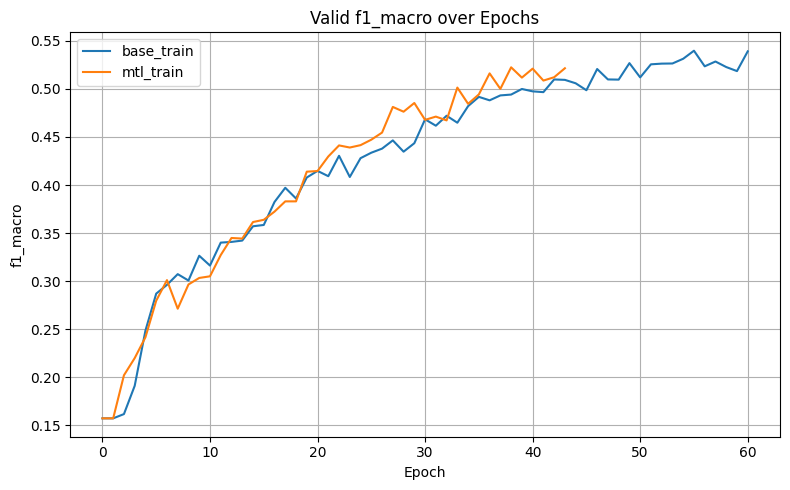

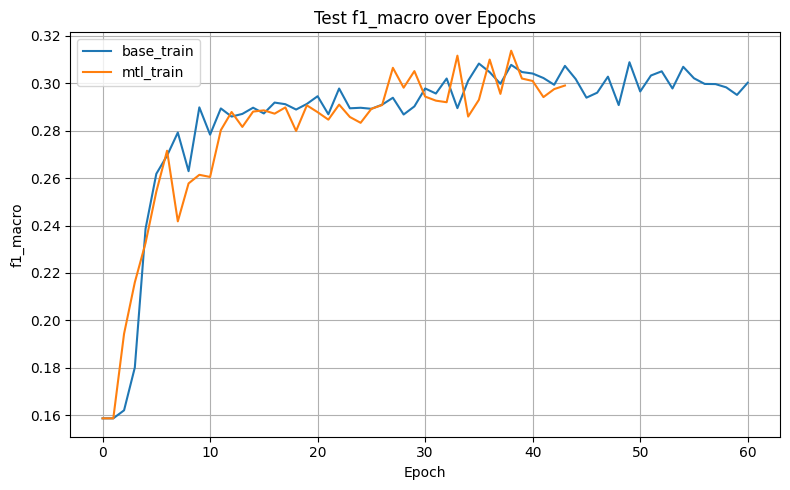

In [18]:
plot_results(results_dict, split="valid", metric='f1_macro')
plot_results(results_dict, split="test", metric='f1_macro')